In [63]:
import matplotlib as mpl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 1. Frame the Problem


The problem posed is whether we can build a model to predict the life expeectancy of a country with features from the WHO life expectancy data set. 

This problem will require a multivariate regression model with supervised batch learning. 

# 2. Get the Data

In [64]:
# import the data, seperate the target values, seperate a test set.

data = pd.read_csv("Life_Expectancy_Data.csv")

# removing leading and trailing whitespace.

data = data.rename(columns=lambda x: x.strip())

# As per the instructions, 'Country' will not be included as a attribute. 
data = data.drop('Country', axis=1)

# 3. Explore the Data to Gain Insights. 

First let's observe the shape of Life expectancy per country:

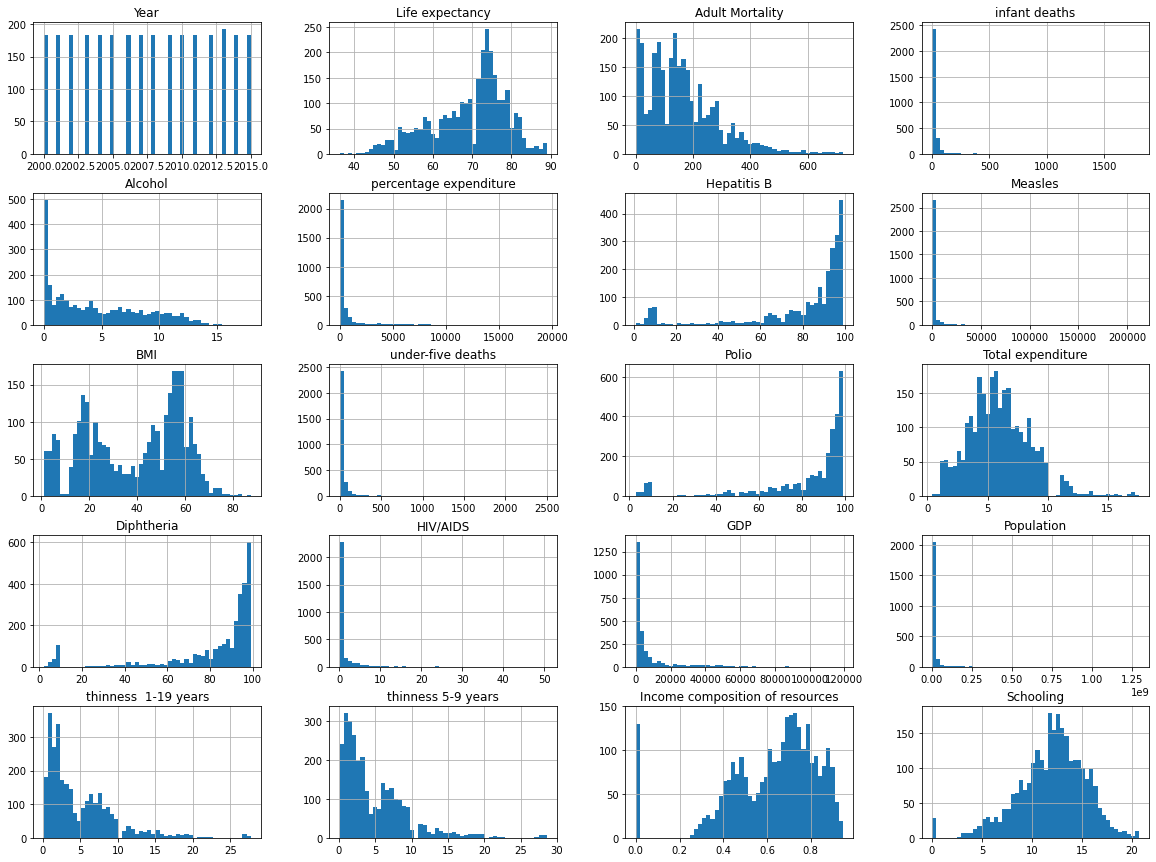

In [65]:
# Creating a histogram matrix to explore the distributions of the variables.
mpl.rcParams['figure.facecolor'] = 'white'
data_hist_matrix = data.hist(bins=50, figsize=(20, 15))
plt.show()

As can be seen from the histogram matrix above, a number of the attributes have skewed distributions. Transforming these into a more normal distribution will benefit the models when they train. 

In [66]:
# transform alcohol, BMI, ICOR, thinness 1- 19 years to logarithm in place of the original values.
data['Alcohol'] = np.log(data['Alcohol'])
data['BMI'] = np.log(data['BMI'])
data['thinness  1-19 years'] = np.log(data['thinness  1-19 years'])


<AxesSubplot:>

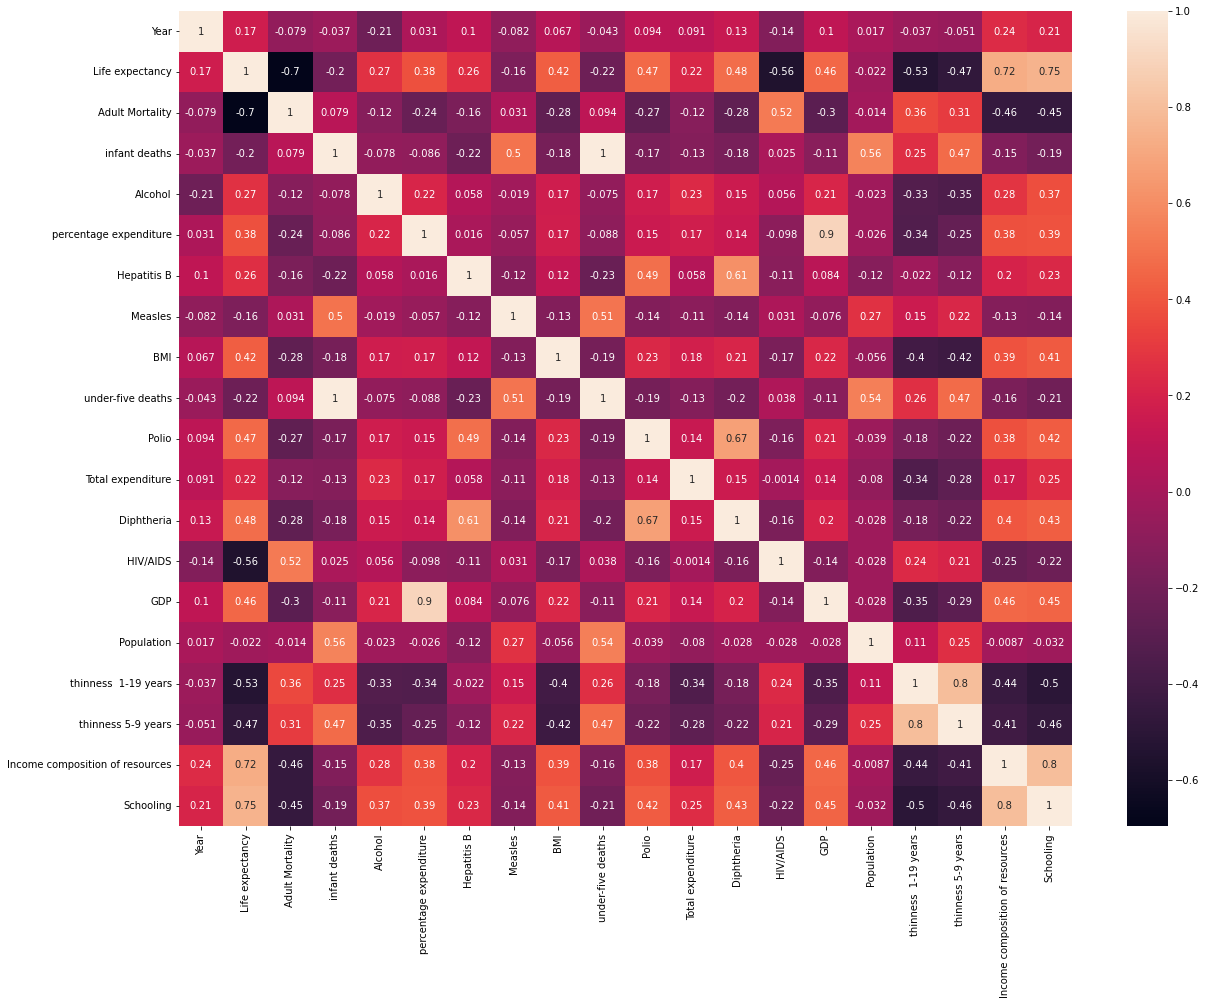

In [67]:
# plotting correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(),
            xticklabels=data.corr().columns,
            yticklabels=data.corr().columns,
            annot=True)

I noted from the correlation scores that there were some redundant variables, such as 'thinness 5-9 years', 'infant deaths', when there are 'thinness  1-19 years' and 'under-five deaths' respectively. I also noted that 'GDP' was highly correlated with 'percentage expenditure', and 'Income composition of resources' was highly correlated with 'Schooling'. Thus, to simplify the dataset, these attributes were removed:

In [68]:
data.drop(['thinness 5-9 years', 'infant deaths', 'GDP', 'Schooling'], axis=1, inplace=True)

<AxesSubplot:>

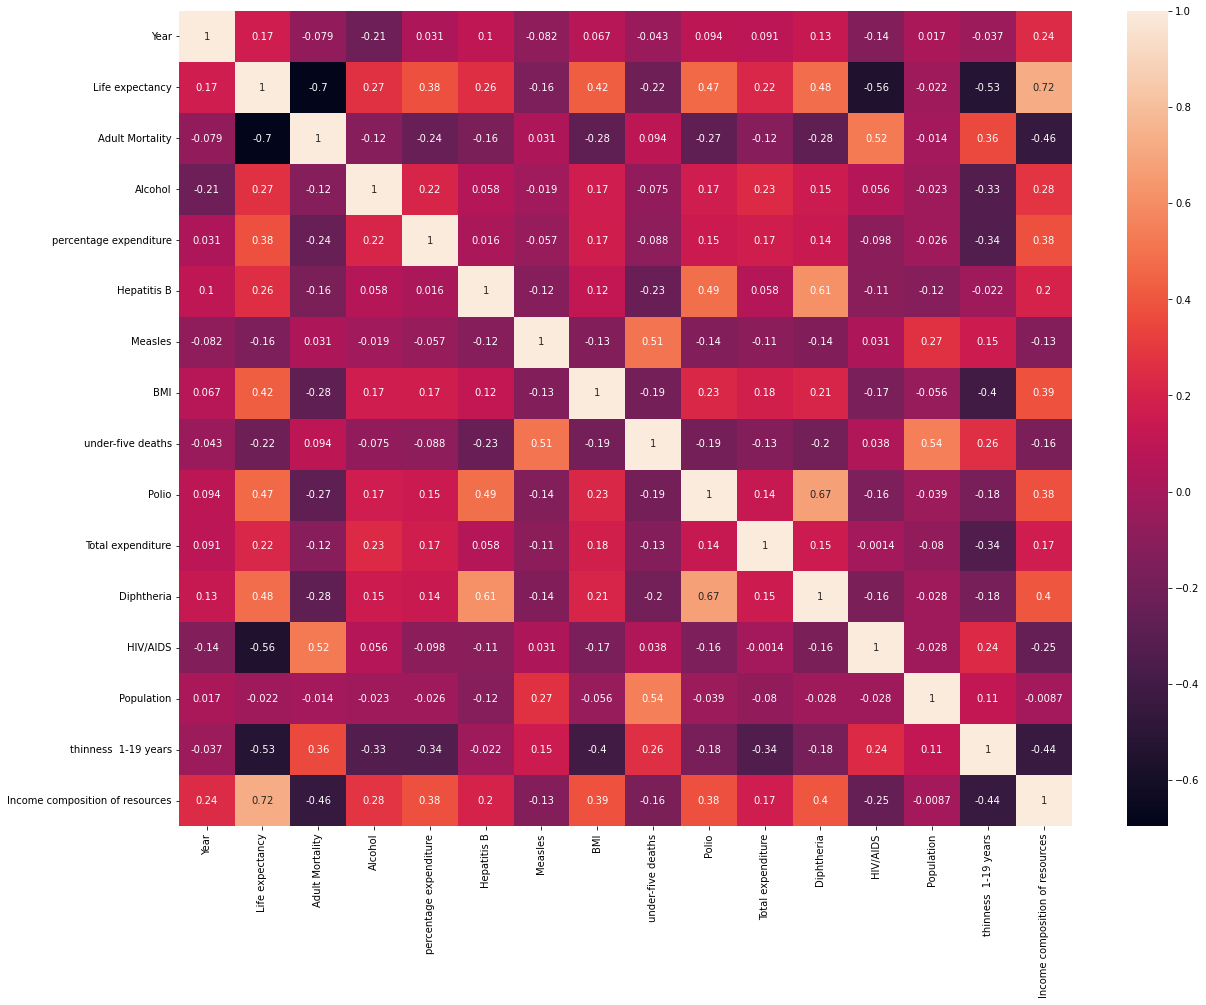

In [69]:
# plotting correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(),
            xticklabels=data.corr().columns,
            yticklabels=data.corr().columns,
            annot=True)

Finally, It could be seen that 'Diphtheria', 'Polio', 'Hepatitis B' were all highly correlated, thus, I combined them into 1 attribute:

In [70]:
# combine 'Diphtheria', 'Polio', 'Hepatitis B' into 1 column in data:
data['Diphtheria, Polio, and Hepatitis B'] = data['Diphtheria'] + data['Polio'] + data['Hepatitis B']
data.drop( ['Diphtheria', 'Polio', 'Hepatitis B', 'thinness  1-19 years'], axis = 1, inplace = True)

<AxesSubplot:>

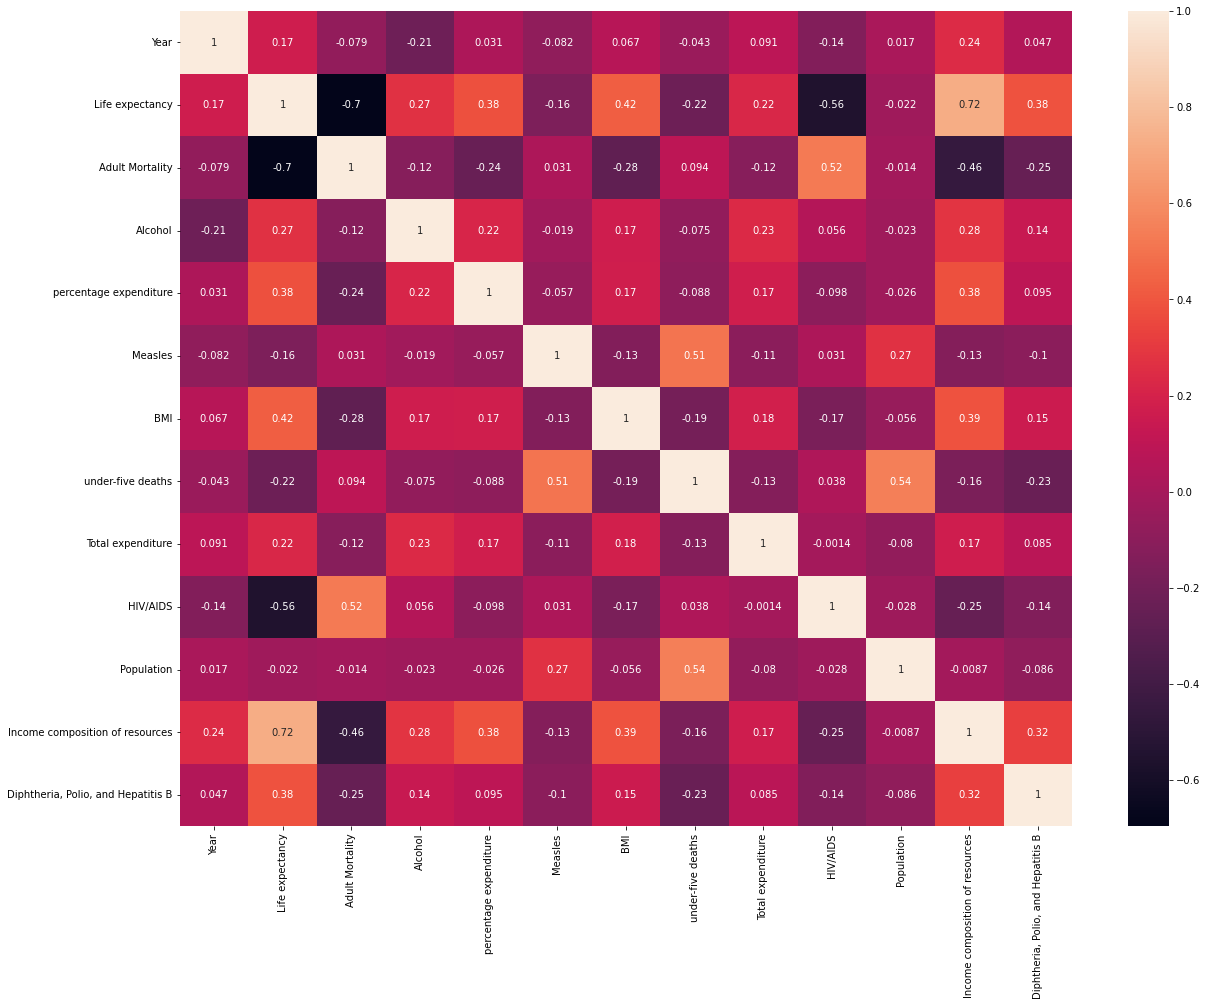

In [71]:
# plotting correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(),
            xticklabels=data.corr().columns,
            yticklabels=data.corr().columns,
            annot=True)

# 4. Prepare the Data for Machine Learning Algorithms


Below is a list of the percentage of missing data for each attribute:

In [72]:
print(round(data.isnull().sum()/len(data)*100, 2))

Year                                   0.00
Status                                 0.00
Life expectancy                        0.34
Adult Mortality                        0.34
Alcohol                                6.60
percentage expenditure                 0.00
Measles                                0.00
BMI                                    1.16
under-five deaths                      0.00
Total expenditure                      7.69
HIV/AIDS                               0.00
Population                            22.19
Income composition of resources        5.68
Diphtheria, Polio, and Hepatitis B    18.82
dtype: float64


I plan on imputing the missing values for each instance if there is a reasonable proportion of values already present. As 'Life expectancy' is missing only 0.34%, and it is the target, I will simply remove all instances with missing 'Life expectancy' data:

In [73]:
# drop instances with missing 'Life expectancy'.
data = data.dropna(subset=['Life expectancy'])

Although 'Population' and 'Hepatitis B', 'Diptheria', Polio' were missing ~ 1/5 values, I allowed their values to be imputed through the pipeline defined below.

As mentioned earlier, I implemented a custom transformer for transforming likely variables into their logarithmic form, to normalise their distributions.  

I then defined a number of subpipelines to impute and standardise numerical data, and encode. They were then combined as `preprocessing_pipeline` using `ColumnTransformer`:

In [74]:
# Defining the pipeline. 

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


#num_attribs = ['Year', 'Adult Mortality', 'Alcohol', 'percentage expenditure', 'Measles', 'BMI', 'under-five deaths', 'Total expenditure', 'HIV/AIDS' , 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Diphtheria, Polio, and Hepatitis B']
num_attribs = ['Year', 'Adult Mortality', 'Alcohol', 'percentage expenditure', 'Measles', 'BMI', 'under-five deaths', 'Total expenditure', 'HIV/AIDS' , 'Population', 'Income composition of resources', 'Diphtheria, Polio, and Hepatitis B']

num_pipeline = Pipeline([
    ('imputer', IterativeImputer(initial_strategy = 'median')),
    ('std_scaler', StandardScaler())
    ])

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs)],
    remainder='drop')

To analyse the performance of different models, I defined a function to assemble their Root Mean Square Error (RMSE) and Mean Absolute Error (MAE), as well as training set fit time and test set fit times:

In [75]:
# a function to output regression performance scores. 

def scores_df(train_scores, test_scores):
    scores_df = pd.DataFrame({'train_RMSE_scores' : np.sqrt(-train_scores['test_neg_mean_squared_error']), 
                                'train_MAE_scores' : -train_scores['test_neg_mean_absolute_error'], 
                                'test_RMSE_scores' : np.sqrt(-test_scores['test_neg_mean_squared_error']),
                                'test_MAE_scores' : -test_scores['test_neg_mean_absolute_error'],
                             'train_fit_time_(s)': train_scores['fit_time'],
                             'test_fit_time_(s)': test_scores['fit_time']})
    return(scores_df)
    # In the interest of making the error measurements more interpretable, I have swapped the signs of the averages, as well as to be able to calculate the sqrt. 

Finally, I split the dataset into training and test sets, so as to be able to validate each model on 'unseen' test data. 

In [76]:
# General function to preprocess and cv, returning RMSE and MAE scores. To be used for each function. 

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# creating the X and y sets.
y_train = train_data['Life expectancy'] 
y_test = test_data['Life expectancy']
X_train = train_data.drop(['Life expectancy'], axis = 1) 
X_test = test_data.drop(['Life expectancy'], axis = 1)


# 5. Select and Train a Model.

## 5.1 Consider several models.

I choose to test a number of regression models: Linear Regressor, Polynomial Regressor, Support Vector Regressor, Decision Tree, Random Forest, XGBoost, and finally a Voting Regressor made up of each of the prior models sans Polynomial Regressor. A pipe was defined for each model, 10-fold cross validation was performed on the test set, then the pipe was trained on the test set and again 10-fold validated on the training set. Each model and pipe was scrupulously checked for data leakage. Finally, the test scores and times were passed to the `scores_df` function defined above for display and for later analysis. 

## Linear Regressor

In [77]:
# Preparing a linear regression model with all attributes.

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lin_reg_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('lin_reg', LinearRegression())
])

lin_reg_train = cross_validate(lin_reg_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_pipe = lin_reg_pipe.fit(X_train, y_train)

# Test set validation.
lin_reg_test = cross_validate(lin_reg_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

lin_reg_df = scores_df(lin_reg_train, lin_reg_test)
lin_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,4.828645,3.377460,3.266578,2.651860,0.072990,0.036971
1,4.209062,3.140629,4.166896,2.926422,0.060320,0.049530
2,4.494827,3.340885,4.617706,3.111553,0.058208,0.041834
3,4.751552,3.406467,5.118647,3.284150,0.113019,0.088619
4,4.731169,3.214945,4.100780,2.768716,0.058067,0.068180
5,4.095494,2.843537,7.478749,4.256041,0.059161,0.041297
6,4.689833,3.331093,4.553633,3.151821,0.064051,0.043061
7,4.417954,3.139812,5.443870,3.754668,0.065322,0.050713
8,4.264054,3.147824,4.599512,3.432310,0.098268,0.055561
9,5.223115,3.605269,4.050696,2.922969,0.057714,0.091488


## Polynomial Regression

As polynomial regression requires transforming the features into their polynomial versions, I defined a seperate dataset for this purpose, using only numerical data. 

In [78]:
# Preparing a polynomial regression model.

from sklearn.preprocessing import PolynomialFeatures

X_train_poly = X_train.drop('Status', axis=1)
X_test_poly = X_test.drop('Status', axis=1)

poly_pipe = Pipeline([('prepro', num_pipeline),
('poly', PolynomialFeatures(degree = 2)),
('lin_reg', LinearRegression())])

train_poly = cross_validate(poly_pipe, X_train_poly, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_poly_pipe = poly_pipe.fit(X_train_poly, y_train)

test_poly = cross_validate(test_poly_pipe, X_test_poly, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

poly_reg_df = scores_df(train_poly, test_poly)
poly_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,3.253591,2.263122,12.711438,3.706417,0.069837,0.037724
1,2.859919,2.235483,3.262205,2.358004,0.064399,0.053647
2,2.937522,2.189691,7.782984,3.170137,0.069893,0.048793
3,3.678139,2.553014,4.381150,2.622268,0.108159,0.089640
4,3.384323,2.257765,2.753351,2.060661,0.072543,0.058894
5,3.154640,2.265483,35.821987,8.656606,0.060099,0.058612
6,3.384993,2.454368,3.363736,2.307057,0.058763,0.045969
7,3.457354,2.352933,4.084353,2.832273,0.068213,0.055714
8,2.795136,2.104010,7.458022,3.603489,0.116481,0.060959
9,3.971971,2.571685,4.336547,2.660388,0.060129,0.089158


## SVR

In [79]:
# preparing a SVR model.

from sklearn.svm import SVR

SVR_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('SVR', SVR())
])

train_SVR = cross_validate(SVR_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_SVR_pipe = SVR_pipe.fit(X_train, y_train)

test_SVR = cross_validate(test_SVR_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

SVR_reg_df = scores_df(train_SVR, test_SVR)
SVR_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,3.780627,2.556071,4.818369,2.989139,0.345173,0.057315
1,3.130556,2.251365,4.293791,3.025378,0.332578,0.067894
2,3.431400,2.432026,4.360609,3.038201,0.327785,0.056901
3,4.016530,2.820924,5.312183,3.434632,0.337564,0.085779
4,3.800299,2.404817,4.317012,3.001313,0.335099,0.073018
5,3.435542,2.227215,4.718644,3.209726,0.333487,0.051869
6,3.687663,2.617919,3.880877,2.814179,0.333714,0.066367
7,4.098995,2.704785,5.338799,3.723221,0.372865,0.068589
8,3.353670,2.315045,5.362807,3.683680,0.351843,0.097831
9,4.153969,2.695954,4.807399,3.064196,0.331838,0.078100


## Decision Tree

In [80]:
# Preparing a DT model.

from sklearn.tree import DecisionTreeRegressor

tree_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('RF', DecisionTreeRegressor())
])

train_tree = cross_validate(tree_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_tree_pipe = tree_pipe.fit(X_train, y_train)

test_tree = cross_validate(test_tree_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

tree_reg_df = scores_df(train_tree, test_tree)
tree_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,3.324858,1.859149,3.588140,2.344068,0.079690,0.040694
1,3.023511,1.923404,2.678572,1.927119,0.215251,0.051445
2,2.927617,1.777778,3.861983,2.257627,0.076079,0.042591
3,3.141043,2.040171,4.260302,2.942373,0.083121,0.082669
4,2.923015,1.601709,4.185001,2.725424,0.083763,0.070655
5,2.892046,1.735043,3.341039,2.184746,0.098978,0.040408
6,3.208815,1.963248,3.665731,2.251724,0.074309,0.048780
7,2.807453,1.611966,3.980361,2.832759,0.070072,0.049520
8,2.741677,1.666239,3.614554,2.615517,0.074257,0.056013
9,2.844946,1.784188,4.496857,2.951724,0.114007,0.089702


It appears that even without tuning, the SVRegressor performs much better, achieving an average RMSE of 4.27(0.507) on 10 folds of the test set.  

## Random Forest

In [81]:
# Preparing a Random Forest model. 

from sklearn.ensemble import RandomForestRegressor

RF_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('RF', RandomForestRegressor())
])

train_RF = cross_validate(RF_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_RF_pipe = RF_pipe.fit(X_train, y_train)

test_RF = cross_validate(test_RF_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

RF_reg_df = scores_df(train_RF, test_RF)
RF_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,2.235394,1.354817,2.142722,1.554729,1.039920,0.282721
1,1.685636,1.148923,1.859352,1.365271,1.013743,0.290113
2,1.947122,1.299017,2.164676,1.412746,1.025780,0.280696
3,2.189815,1.415645,2.771195,1.971034,1.024572,0.300035
4,2.005568,1.353812,2.740235,1.926085,0.995058,0.308923
5,2.040810,1.286192,2.897513,1.988017,1.000379,0.291982
6,1.903404,1.249675,2.634732,1.811810,0.996094,0.291487
7,1.952704,1.169962,3.428961,2.311569,0.987719,0.288338
8,1.729543,1.172526,2.354348,1.534672,1.040680,0.290504
9,1.929637,1.188457,2.665367,1.915345,1.008454,0.307725


## XGBoost

In [82]:
# Preparing a XGBoost model.

from xgboost import XGBRegressor


xgb_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('xgb', XGBRegressor())
])

train_xgb = cross_validate(xgb_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_xgb_pipe = xgb_pipe.fit(X_train, y_train)

test_xgb = cross_validate(test_xgb_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

xgb_reg_df = scores_df(train_xgb, test_xgb)
xgb_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,2.184725,1.382095,2.530740,1.817079,0.434578,0.256541
1,1.729353,1.283718,2.430231,1.718055,0.422490,0.275049
2,1.945049,1.318989,2.472143,1.852766,0.441833,0.245202
3,2.338719,1.578580,2.706102,2.023101,0.463673,0.229200
4,1.995012,1.461032,3.015443,2.325942,0.495346,0.277649
5,2.049796,1.382657,2.821163,1.977220,0.424309,0.261089
6,1.927440,1.321086,2.650675,1.936059,0.431917,0.235692
7,1.828451,1.262884,3.404736,2.539420,0.442095,0.245439
8,1.890980,1.283549,2.698276,1.832372,0.423515,0.286441
9,1.957011,1.325971,2.669410,1.869624,0.429286,0.286455


## Voting Regressor

In [83]:
# Preparing a VotingRegressor model. 

from sklearn.ensemble import VotingRegressor

voting_pipe = Pipeline([
    ('prepro', preprocess_pipeline),
    ('voting', VotingRegressor(
        estimators = [
            ('lin_reg', LinearRegression()),
            ('tree', DecisionTreeRegressor()),
            ('SVR', SVR()),
            ('RF', RandomForestRegressor()),
            ('xgb', XGBRegressor())
        ]
    ))
])

train_voting = cross_validate(voting_pipe, X_train, y_train, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

test_voting_pipe = voting_pipe.fit(X_train, y_train)

test_voting = cross_validate(test_voting_pipe, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

voting_reg_df = scores_df(train_voting, test_voting)
voting_reg_df

,train_RMSE_scores,train_MAE_scores,test_RMSE_scores,test_MAE_scores,train_fit_time_(s),test_fit_time_(s)
0,2.689003,1.694939,2.433186,1.782321,1.647025,0.473095
1,2.091222,1.459601,2.181459,1.691597,1.647395,0.623860
2,2.284269,1.612872,2.871540,1.861042,1.661849,0.481152
3,2.724608,1.903111,3.380960,2.310117,1.693402,0.576011
4,2.495738,1.685939,2.848727,1.914468,1.630673,0.520797
5,2.300586,1.489993,3.227850,2.278984,1.610313,0.543208
6,2.403743,1.680980,2.927691,1.994797,1.639359,0.532910
7,2.392865,1.596804,3.967431,2.679502,1.664436,0.577463
8,2.129357,1.507990,2.816101,1.934387,1.646271,0.495596
9,2.618014,1.674494,2.986998,2.059301,1.607554,0.572193


## DNN

In [84]:
# from sklearn.neural_network import MLPRegressor

# print('full set scores')
# full_score = model_function(MLPRegressor(), data, preprocess_pipeline)

# print('simple set scores')
# simple_score = model_function(MLPRegressor(), simple_data, num_pipeline)


## Comparison of Model Performance

I compared the RMSE, MAE, and training set fit times (as the training sets are larger than the test sets) to comapare each model:

In [85]:
# concatenate the score for each model

# box plots of RMSE scores
test_RMSE_scores_df = pd.concat( objs = [
                                lin_reg_df['test_RMSE_scores'],
                                poly_reg_df['test_RMSE_scores'],
                                SVR_reg_df['test_RMSE_scores'],
                                tree_reg_df['test_RMSE_scores'],
                                RF_reg_df['test_RMSE_scores'],
                                xgb_reg_df['test_RMSE_scores'],
                                voting_reg_df['test_RMSE_scores']], axis = 1)
                                
column_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Decision Tree', 'Random Forest', 'XGBoost', 'Voting']

test_RMSE_scores_df.columns = column_names

test_MAE_scores_df = pd.concat( objs = [
                                lin_reg_df['test_MAE_scores'],
                                poly_reg_df['test_MAE_scores'],
                                SVR_reg_df['test_MAE_scores'],
                                tree_reg_df['test_MAE_scores'],
                                RF_reg_df['test_MAE_scores'],
                                xgb_reg_df['test_MAE_scores'], 
                                voting_reg_df['test_MAE_scores']
                                ], axis = 1)

test_MAE_scores_df.columns = column_names


test_train_times_df = pd.concat( objs = [
                                lin_reg_df['train_fit_time_(s)'],
                                poly_reg_df['train_fit_time_(s)'],
                                SVR_reg_df['train_fit_time_(s)'],
                                tree_reg_df['train_fit_time_(s)'],
                                RF_reg_df['train_fit_time_(s)'],
                                xgb_reg_df['train_fit_time_(s)'],
                                voting_reg_df['train_fit_time_(s)'],
                                ], axis = 1)

test_train_times_df.columns = column_names

I used horizontally stacked boxplots to compare regression error, and a bar plot to compare training times:

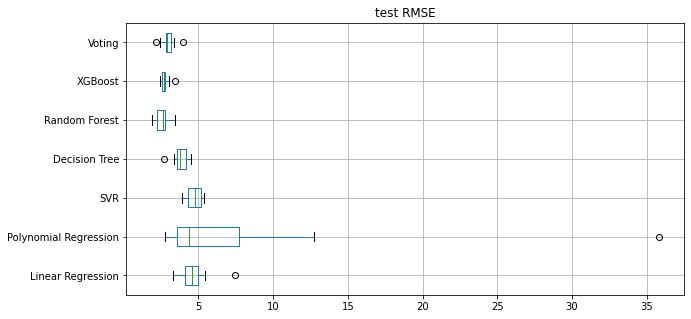

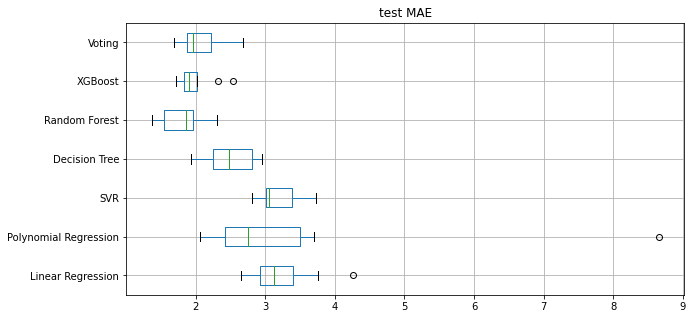

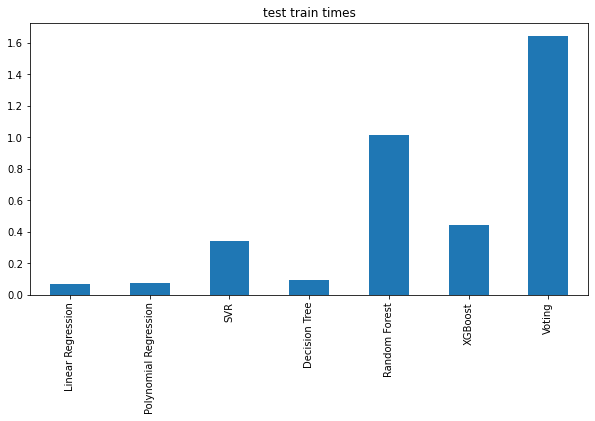

In [86]:
# horizontal box plot of RMSE of each model.

test_RMSE_scores_df.boxplot(figsize=(10,5), vert = False)
plt.title('test RMSE')
plt.show()

# Horizontal box plot of MAE for each model.
test_MAE_scores_df.boxplot(figsize=(10,5), vert = False)
plt.title('test MAE')
plt.show()

# bar plot of test_train_times_df
test_train_times_df.mean().plot(kind = 'bar', figsize=(10,5))

plt.title('test train times')
plt.show()

For the two box-plots of RMSE and MAE for each model, Random Forest and XGBoost had the lowest average errors. In fact, Random Forest achieved the lowest error, however, with more variation than XGBoost overall. 

That being said, if the average training times on the training sets is comparesd, XGBoost is 4 times faster to train. Thus, considering that the distribution of error values is similar, but XGBoost is much faster to train, it would be practical to select XGBoost as the regression model to predict 'Life expectancy'.

## 5.2 Fine-tuning the models

Having selected XGBoost, I will now use a cross-validated grid search to attempt to optimise its performance. 

In [87]:
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [94]:
# define a parameter grid for xgboost grid search
# please note: this will run for a while. 
from sklearn.model_selection import GridSearchCV

# A parameter grid for XGBoost
xgboost_param_grid = {
        'xgb__n_estimators': [2000, 4000],
        'xgb__colsample_bytree': [0.6, 0.8],
        'xgb__gamma': [0.5, 0.7],
        'xgb__max_depth': [4, 10],
        'xgb__min_child_weight': [0.5, 1],
        'xgb__subsample': [0.8, 1],
        }

xgb_grid_search_pipe = xgb_pipe

opt_xgb_grid_search = GridSearchCV(
                                estimator = xgb_grid_search_pipe,
                                param_grid = xgboost_param_grid, 
                                cv = 3, 
                                scoring = 'neg_mean_squared_error', 
                                verbose=1)

opt_xgb_grid_search.fit(X_train, y_train)

print(opt_xgb_grid_search.best_params_)

test_opt_xgb = cross_validate(opt_xgb_grid_search, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


KeyboardInterrupt: 

In [ ]:
opt_xgb_grid_search.best_params_

{'xgb__colsample_bytree': 0.6,
 'xgb__gamma': 0.5,
 'xgb__max_depth': 4,
 'xgb__min_child_weight': 0.5,
 'xgb__n_estimators': 2000,
 'xgb__subsample': 0.8}

In [ ]:
test_opt_xgb = cross_validate(opt_xgb_grid_search.best_estimator_, X_test, y_test, cv = 10, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'])

<AxesSubplot:>

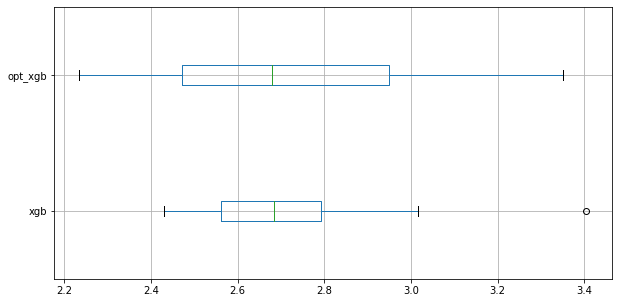

In [97]:
# compare the xgboost and grid search xgboost in a dataframe

xgb_compare_df = pd.DataFrame({ 'xgb' : test_xgb['test_neg_mean_squared_error'],'opt_xgb' : test_opt_xgb['test_neg_mean_squared_error']})

xgb_compare_df = xgb_compare_df.apply(lambda x: np.sqrt(-x), axis = 1)

xgb_compare_df.boxplot(figsize=(10,5), vert = False)

After applying a grid search to optimize the hyperparameters, we can see that a lower minimum value has been achieved, however the total range of values has been increased, and the average has not shifted.

Overall, I have shown that to predict 'Life expectancy' with the specific feature engineering I chose, XGBoost is the superior model, and that after hyperparameter optimization, a minimum RMSE of 2.23 was achieved. 